In [17]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from scipy.stats import gaussian_kde
import os
import yaml
import h5py
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import time

import warnings

In [18]:
import sys
sys.path.append(r'../tools_F-J/')
sys.path.append(r'../tools_F-J/toollib_DisbaCode')
from objective_function import (ObjectiveFunctionDerivativeUsed, Forward)
from toollib_DisbaCode import forward
from toollib_DisbaCode import objective_function
from toollib_DisbaCode import empirical_relation
from toollib_DisbaCode import plot_disp
from toollib_DisbaCode import plot_model
from toollib_DisbaCode import plot_lcurve
from toollib_DisbaCode import plot_inversion    
from toollib_DisbaCode import plot_kernel

#from toollib_standard import maplib
#from toollib_standard import mathlib
#from toollib_standard import filelib
#from toollib_standard import stacklib
from toollib_standard import plotlib

In [19]:
flag_project = 1 # 0--regular; 1--repartrition; 2--voronoi
file_init = 'initial/initial_model_5.txt'

In [20]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [21]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.2_01-01/


In [22]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary


In [23]:
dir_ds = dir_project + info_basic['dir_ds']
dir_partition = dir_project + info_basic['dir_partition']
dir_inv_dispernet = dir_project + info_basic['dir_inv_dispernet'] 
d_len = info_basic['d_len']
f = info_basic_bi['f']
c = np.linspace(info_basic['c_min'], info_basic['c_max'], info_basic['c_num'])

In [24]:
nums = [1]
key_subworks_all = info_basic['key_subworks']
key_subworks = []
for num in nums:
    for key_subwork in key_subworks_all:
        if str(num) == key_subwork.split('--')[0]:
            key_subworks.append(key_subwork)
            break
#key_subworks = info_basic['key_subworks']
key_subworks

['1--08-03']

In [25]:
file_config = 'config_inv_fund.yml'
#file_config = 'config_inv.yml'
flag_forward = 1

In [26]:
if file_config == 'config_inv.yml':
    #info_basic['dir_image_inv'] = info_basic['dir_inv_dispernet'] + 'image_inv_' + info_basic['tag'] + '/'
    info_basic['dir_invfile'] = info_basic['dir_inv_dispernet'] + 'inversion/'
    info_basic['dir_disp_model'] = info_basic['dir_inv_dispernet'] + 'disp_model/'
    info_basic['dir_model'] = info_basic['dir_inv_dispernet'] + 'model/'
    dir_image = dir_project + info_basic['dir_image'] + 'inversion/'
    dir_invfile = dir_project + info_basic['dir_invfile']
    dir_disp_model = dir_project + info_basic['dir_disp_model']
    dir_model = dir_project + info_basic['dir_model']
    
else:
    #info_basic['dir_image_inv_fund'] = info_basic['dir_inv_dispernet'] + 'image_inv_fund_' + info_basic['tag'] + '/'
    info_basic['dir_invfile_fund'] = info_basic['dir_inv_dispernet'] + 'inversion_fund/'
    info_basic['dir_disp_model_fund'] = info_basic['dir_inv_dispernet'] + 'disp_model_fund/'
    info_basic['dir_model_fund'] = info_basic['dir_inv_dispernet'] + 'model_fund/'
    dir_image = dir_project + info_basic['dir_image'] + 'inversion_fund/'
    dir_invfile = dir_project + info_basic['dir_invfile_fund']
    dir_disp_model = dir_project + info_basic['dir_disp_model_fund']
    dir_model = dir_project + info_basic['dir_model_fund']
if not os.path.exists(dir_image):
    os.mkdir(dir_image)
if not os.path.exists(dir_invfile):
    os.mkdir(dir_invfile)
if not os.path.exists(dir_disp_model):
    os.mkdir(dir_disp_model)
if not os.path.exists(dir_model):
    os.mkdir(dir_model)

### Forard and plot estimated disp and Vs

In [27]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 

In [28]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [29]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
for key in info_basic['key_subworks']:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [30]:
dir_this = os.getcwd()
dir_this

'/home/harmon/data/git_repo/SGB_tomography_project'

1--08-03
elapsed time:     0.575
finish 1/1


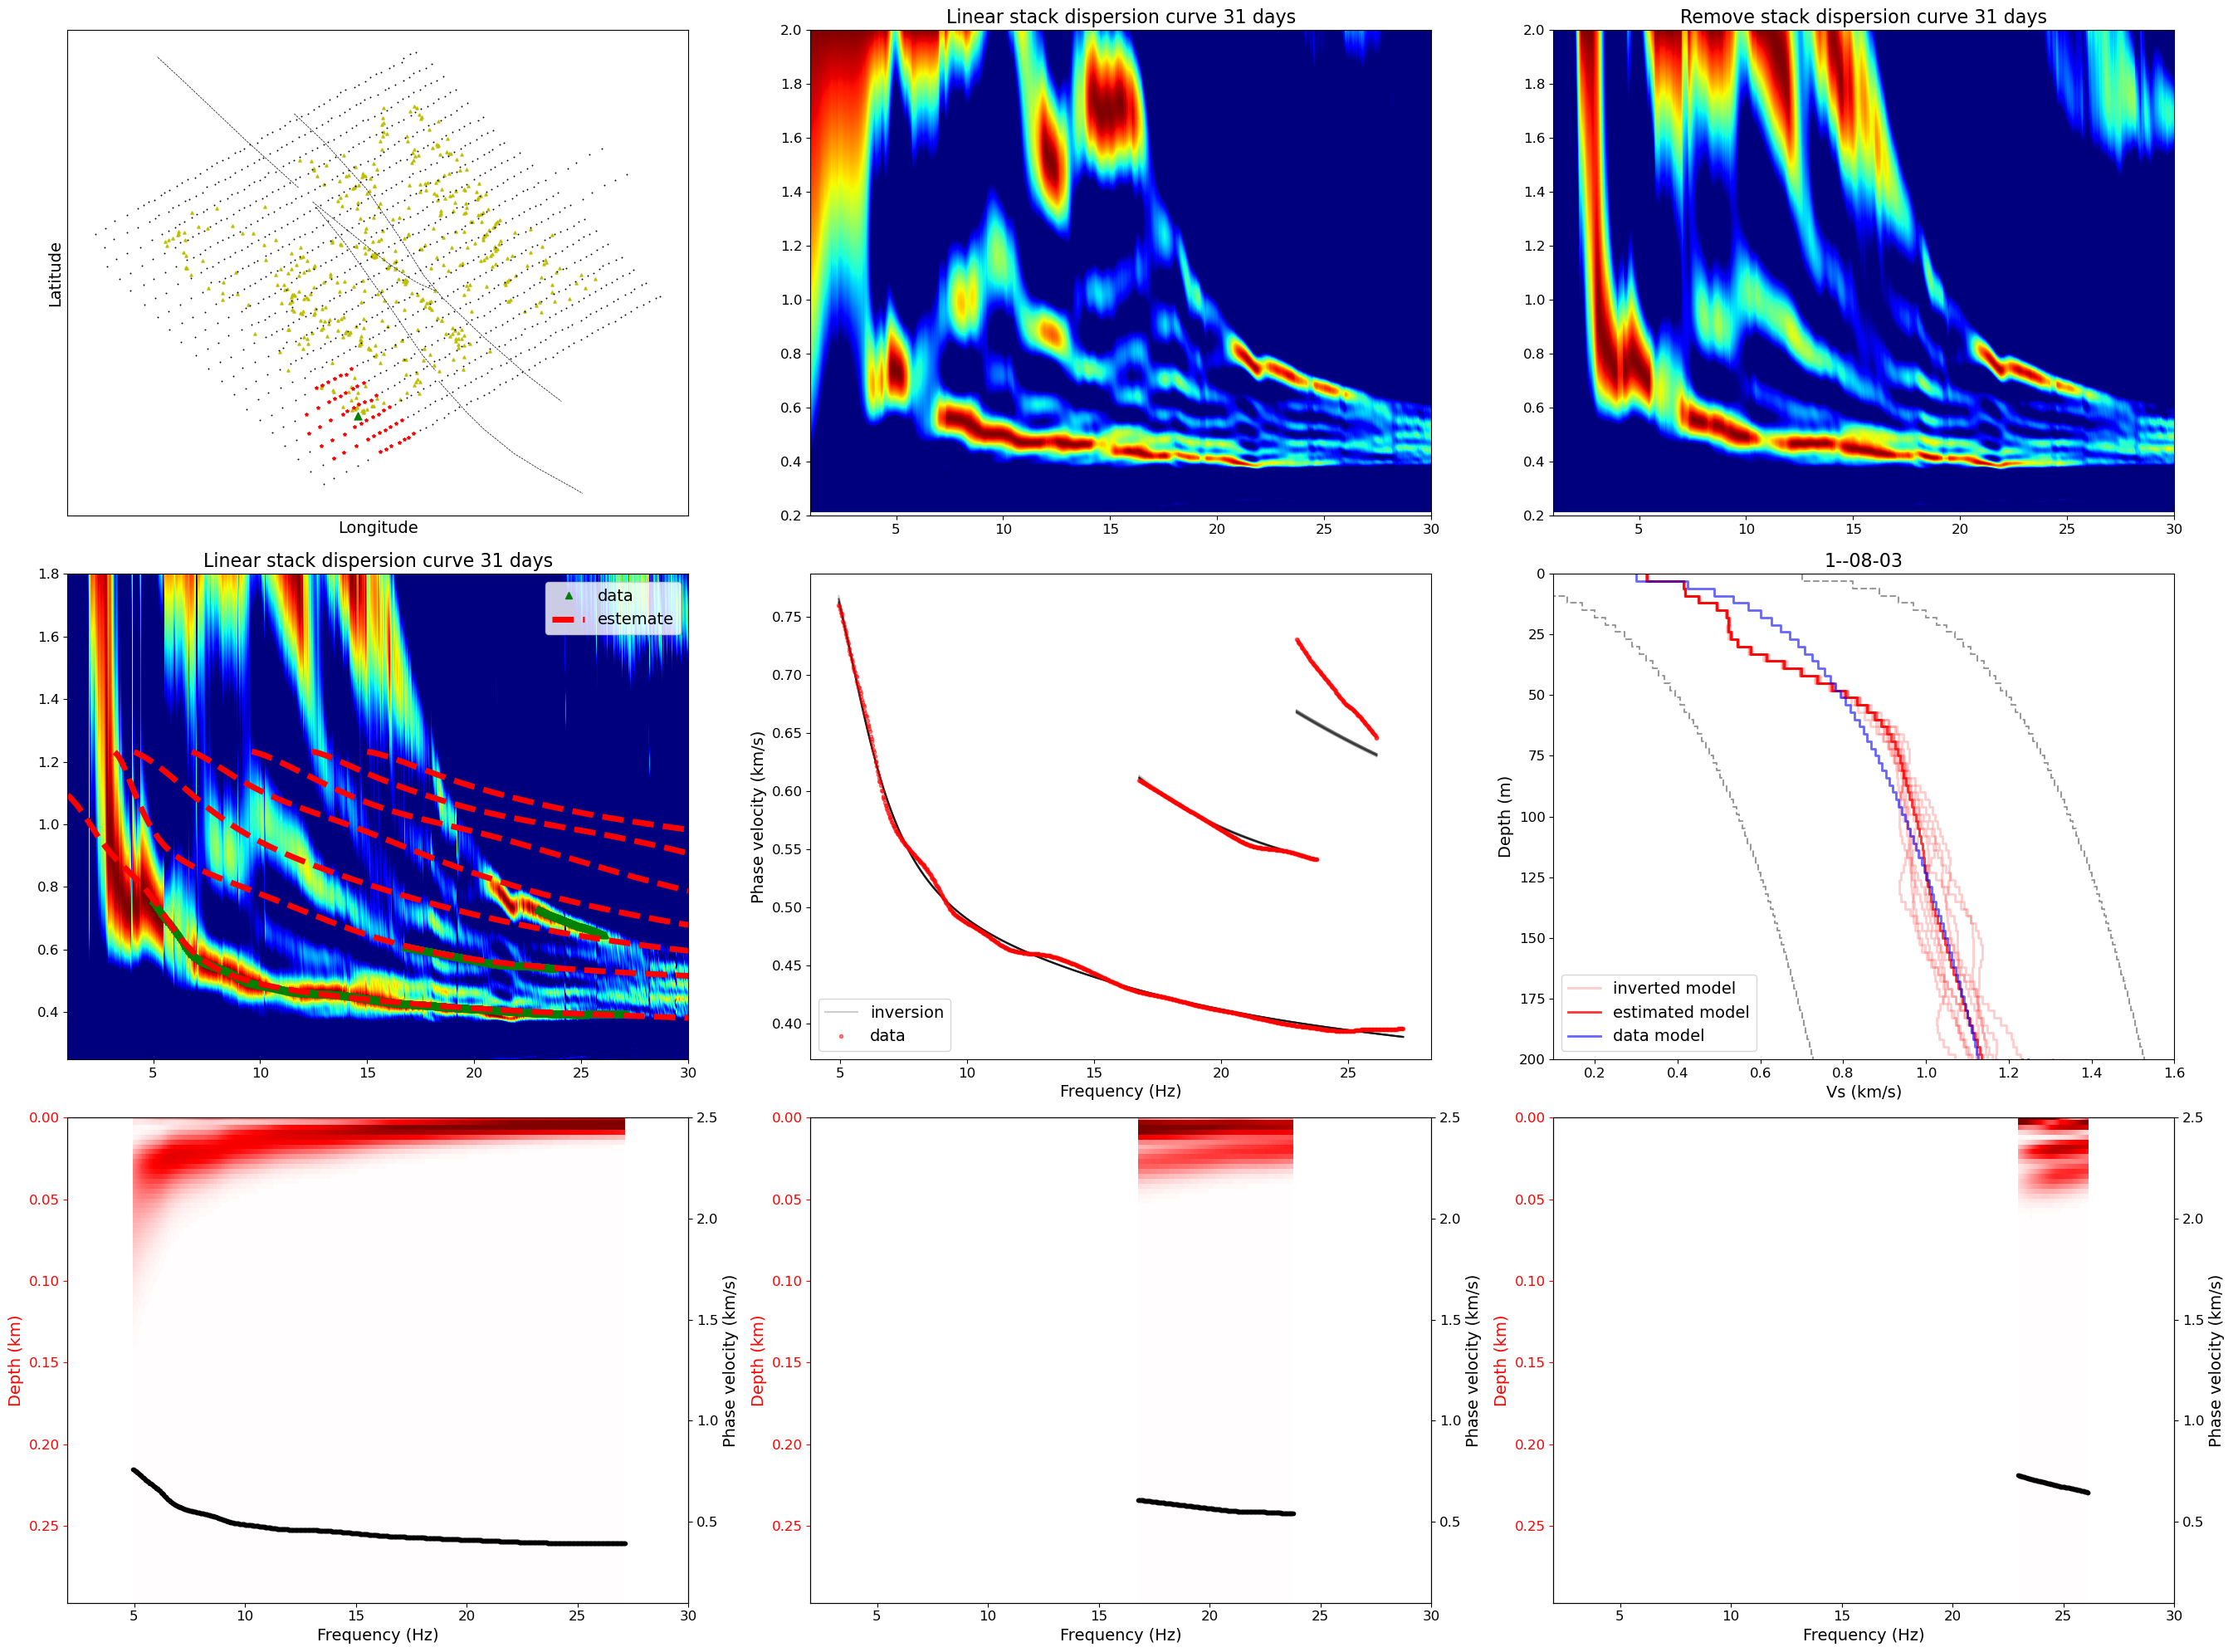

In [31]:
#key_subworks = ['25-06']
c_map = 'jet'
v_max = None
v_min = 0.1

#s.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/'+dir_project+'inv_dispernet')

with open(dir_project + info_basic['dir_inv_dispernet']+file_config, 'r') as fp:
    config = yaml.safe_load(fp)

#with open(dir_inv_dispernet + 'initial/initial_tag.yaml', 'r') as fp:
#    tag = yaml.safe_load(fp)

all_disp = 0
show_init = 0
xlim_f = [1,30]
ylim_c = [0.25,1.8]
clim = [0,1]

flag_num = 0

dir_this = os.getcwd()

for key_subwork in key_subworks:
    key_subwork = str(key_subwork)
    print(key_subwork)
    fig,ax = plt.subplots(3,3,figsize=(27,20))

    data_file = 'data/ds_'+key_subwork+'curve.txt'
    file_model = 'model_'+key_subwork+'.txt'

    if os.path.exists(dir_invfile+file_model):
        os.remove(dir_invfile+file_model)

    file_inv =  'ds_'+key_subwork+'curve/'
    if not os.path.exists(dir_invfile+file_inv):
        print(key_subwork+'data file not exist')
        plt.close()
        continue


    os.chdir(dir_project_workspace +'/'+name_project+'/inv_dispernet/')
    disp_data = np.loadtxt(data_file)
    data_name = 'ds_'+key_subwork+'curve'
    ax[1][1] = plot_inversion.plot_disp(config, data_name, all_disp,ax[1][1])
    # s wave velocity inversion
    
    #file_init = 'initial/initial_model_'+str(tag[key_subwork])+'.txt'
    ax[1][2],model,fmt = plot_inversion.plot_model(config, data_name, show_init, file_model,file_init,ax[1][2])
    os.chdir(dir_this + '/')

    np.savetxt(dir_model+file_model, model, fmt=fmt)


    # forward
    filename = dir_disp_model +  'disp_model_'+key_subwork+'.txt'
    if flag_forward == 1:
        
        max_mode = 6
        
        forward.forward_cal(info_basic,max_mode,dir_model+file_model,filename)


    disp_model = np.loadtxt(filename)


    #os.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/')
    ds = h5py.File(dir_ds+'ds_'+key_subwork+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]
    title0 = "Linear stack dispersion curve "+str(d_len)+' days'
    ax[1][0].set_xlim(xlim_f)
    ax[1][0].set_ylim(ylim_c)
    #ax[0] = plot_fj(ax[0],ds_remove,title0,f,c,xlim_f,0,clim)
    ax[1][0] = plotlib.plot_fj(ax[1][0],ds_remove,title0,f,c,0,v_min = v_min,v_max=v_max,c_map=c_map)
    
    

    
    modes = set(disp_data[:, 2].astype(int))
    for m in modes:
        d = disp_data[disp_data[:, 2] == m]
        if m==0:
            ax[1][0].plot(d[:, 0], d[:, 1], 'g^',label='data')
        else:
            ax[1][0].plot(d[:, 0], d[:, 1], 'g^')

    modes = set(disp_model[:, 2].astype(int))
    for m in modes:
        d = disp_model[disp_model[:, 2] == m]
        if m==0:
            ax[1][0].plot(d[:, 0], d[:, 1], 'r--',label='estemate',linewidth=5)
        else:
            ax[1][0].plot(d[:, 0], d[:, 1], 'r--',linewidth=5)
    ax[1][0].legend()
    ax[1][2].set_title(key_subwork)


    #plt.tight_layout()
    #plt.savefig(dir_image+'inversion_'+key_subwork+'.png',dpi=60)
    #plt.close()
    flag_num += 1
    

    #os.chdir('/home/harmon/data/git_repo/F-J_Workflow/San_Jasinto/')
    fmin = 2
    fmax = 30
    cmin = 0.1
    cmax = 2.5
    vmax = 0.3
    
    file_disp = dir_project + info_basic['dir_inv_dispernet']+'data/ds_'+key_subwork+'curve.txt'
    file_model = dir_model+'model_'+key_subwork+'.txt'
    disp = np.loadtxt(file_disp)
    m = int(max(set(disp[:,2])))
    
    #fig,ax = plt.subplots(1,m+1,figsize=(7*(m+1),6))
    if m > 2:
        m = 2
    for mode in range(m+1):
        #print(mode)
        #ax[2][mode] = plot_kernel.kernel_plot(fmin,fmax,cmin,cmax,file_disp,file_model,mode,vmax,ax[2][mode])
        
        try:
            ax[2][mode] = plot_kernel.kernel_plot(fmin,fmax,cmin,cmax,file_disp,file_model,mode,vmax,ax[2][mode])
        except:
            print('error')
    
    #ax[0][1] = plot_kernel.kernel_plot(fmin,fmax,cmin,cmax,file_disp,file_model,1,vmax,ax[0][1])
    #ax[1][0] = plot_kernel.kernel_plot(fmin,fmax,cmin,cmax,file_disp,file_model,2,vmax,ax[1][0])
    #ax[1][1] = plot_kernel.kernel_plot(fmin,fmax,cmin,cmax,file_disp,file_model,3,vmax,ax[1][1])


    xlim_T = [-1,1]
    #start = info_basic_bi['start'][key_subwork]
    #interval = info_basic_bi['interval'][key_subwork]
    #flag_time = info_basic_bi['flag_time'][key_subwork]
    # plot area
    #stalistname = dir_project+info_basic['stalistname']
    #stainfo = pd.read_excel(stalistname+'.xlsx',key_subwork)
    stalist = stations_partition[key_subwork]
    lat_stations_this = lat_stations_partition[key_subwork]
    lon_stations_this = lon_stations_partition[key_subwork]
    nsta = len(stalist)
    
    ax[0][0]=plotlib.plot_area(ax[0][0],lon_stations_all,lat_stations_all,lon_stations_this,lat_stations_this,markersize = 0.75 ,markersize2 = 3)
    ax[0][0].scatter(lon_centroid_partition,lat_centroid_partition,marker='^',color='y',s=5)
    for i in range(len(faults)):
        ax[0][0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw = 0.5)
    ax[0][0].scatter(np.mean(lon_stations_this),np.mean(lat_stations_this),marker='^',color='g',s=40)
    


    # plot ncfs and ncfstW
    ds = h5py.File(dir_ds+'ds_'+key_subwork+'.h5', 'r')
    ds_linear = ds['ds_linear'][0]
    ds_remove = ds['ds_remove'][0]
    ds_linear = plotlib.smooth_ds(ds_linear)
    ds_remove = plotlib.smooth_ds(ds_remove)
    title0 = "Linear stack dispersion curve "+str(d_len)+' days'
    ax[0][1] = plotlib.plot_fj(ax[0][1],ds_linear,title0,f,c,0,v_min=v_min,v_max=v_max,c_map=c_map)
    ax[0][1].set_xlim(xlim_f)

    title0 = "Remove stack dispersion curve "+str(d_len)+' days'
    ax[0][2] = plotlib.plot_fj(ax[0][2],ds_remove,title0,f,c,0,v_min=v_min,v_max=v_max,c_map=c_map)
    ax[0][2].set_xlim(xlim_f)



    plt.tight_layout()
    #plt.savefig(dir_image+'Sens-kernel_'+key_subwork+'.png',dpi=60)
    plt.savefig(dir_image+'invplot_all_'+key_subwork+'.png',dpi=60)
    

    print('finish '+str(flag_num)+'/'+str(len(key_subworks)))
    #plt.close()

In [32]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)